<a href="https://colab.research.google.com/github/pr31988/PyTorch-Fundamentals/blob/main/_PyTorch_WorkFlow_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Workflow covered:
  1. data: (prepare & load)
  2. Build a Model
  3. Fitting model to data (training)
  4. Making predictions & evaluating the model (Inference)
  5. saving & loading the Model
  6. Putting it all together

In [1]:
import torch
from torch import nn # nn contains all building blocks of pyTorch neural Networks
import matplotlib.pyplot as plt

# check torch version
torch.__version__

'2.5.1+cu121'

Machine Learning mainly Game of two parts:
1. Turn Data into numbers
2. build a model to learn patterns in those numbers

# first example with **Linear regression** to train a model & draw pattern

In [19]:
# y = a + b * X --> b is slope of line

## create parameters
weight = 0.7
bias = 0.2

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2140],
         [0.2280],
         [0.2420],
         [0.2560],
         [0.2700],
         [0.2840],
         [0.2980],
         [0.3120],
         [0.3260]]))

In [20]:
len(X), len(y)

(50, 50)

Splitting data into Training & Test sets(one of the most important concept in machine learning)

In [21]:
# create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [31]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
  plots training data, test data & compares prediction
  """

  #plot training data in red
  plt.scatter(train_data,train_labels, s=4, c="r", label="Training data")

  #plot test data in green
  plt.scatter(test_data, test_labels, s=4, c="g", label="Test data")

  if predictions is not None:
    # plot the predictions if any
    plt.scatter(test_data, predictions, c="b", label="predictions")

  # show the legend
  plt.legend(prop={"size": 15})


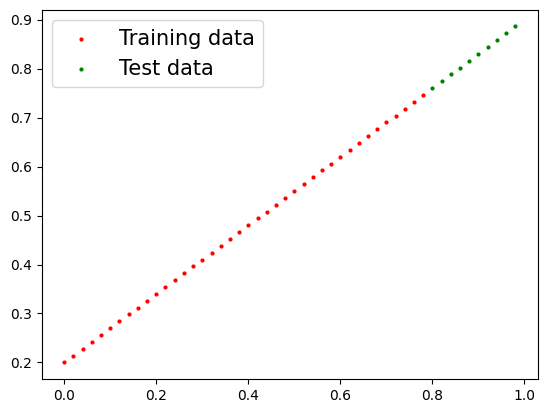

In [23]:
plot_prediction();

create a Model using training data, Model will determine weight & bias values

what our Model does:
1. start with random values (wight & bias)
2. Look at training data and adjust these random values(or get closer to) ideal values (the actual weight & bias we used to create training & test data)

to do so it uses 2 main algorithms:
1. Gradient descent   - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [24]:
from torch import nn

# create a linear Regression Model class
class LinearRegressionModel(nn.Module):  # <-- almost everything in pyTorch is inheritted from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,      # --> start with a random weight and try to adjust it to ideal weight
                                            requires_grad=True,
                                            dtype=torch.float32))

    self.bias = nn.Parameter(torch.rand(1,         # --> start with a random bias and try to adjust it to ideal bias
                                        requires_grad=True,
                                        dtype=torch.float32))

  # forward method to define the computation in the module
  def forward(self, x: torch.Tensor) -> torch.Tensor:   # <-- "x" is the input data
      return self.weights * x + self.bias # linear regression formula

  PyTorch essentials:
  * torch.nn   -   provides all building blocks [its a tool set]
  * torch.nn.Parameter - const values our Model should learn & predict
  * torch.nn.Module  - base class
  * torch.optim - optimize parameters to get actuals
  * def forward - takes data from nn.Module and defines what happens in {forward} computation

In [25]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()  # --> create a random instance of the class (this is subclass on nn.Module)

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [26]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

# Making prediction with torch.inference_mode()
to check our Models prediction power lets see how it predicts y_test based on x_test

 --> when we pass data to the Model its going to run it through forward method


In [27]:
# before using prediction power of our Model
y_test

tensor([[0.7600],
        [0.7740],
        [0.7880],
        [0.8020],
        [0.8160],
        [0.8300],
        [0.8440],
        [0.8580],
        [0.8720],
        [0.8860]])

In [28]:
# with inference method, model is solely predicting values and not training the model. It is not keeping track of the things but just deriving the infenrence
# long story short ***Code runs faster***

with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])

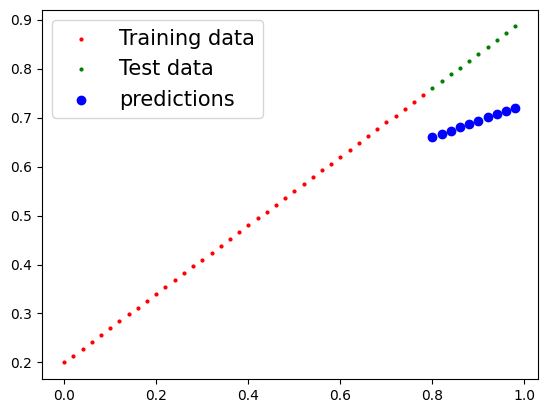

In [32]:
plot_prediction(predictions=y_preds)